In [1]:
import jax
import distrax
import seaborn as sns
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from rebayes_mini.methods.gauss_filter import GaussianFilter
from rebayes_mini.methods.adaptive import ExpfamRLPR

In [2]:
from matplotlib.animation import FuncAnimation

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rc("text", usetex=True)
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 15

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
p_change = 0.005
p_change = 0.00

def step(params, key):
    key_x, key_y, key_change, key_params = jax.random.split(key, 4)

    change = jax.random.uniform(key_change) < p_change

    key_theta0, key_theta1, key_theta2 = jax.random.split(key_params, 3)
    theta0 = jax.random.uniform(key_theta0, (1,), minval=-3, maxval=3)
    theta1 = jax.random.uniform(key_theta1, (1,), minval=-3, maxval=3)
    theta2 = jax.random.uniform(key_theta2, (1,), minval=-3, maxval=3)

    params_change = jnp.concat([theta0, theta1, theta2])
    params = params * (1 - change) + params_change * change

    x = jax.random.uniform(key_x, minval=-2, maxval=2)
    x = jnp.c_[1, x, x ** 2]

    yclean = x @ params
    y = yclean + jax.random.normal(key_y)

    out = {
        "params": params,
        "y": y,
        "x": x,
        "change": change,
        "yclean": yclean,
    }

    return params, out

In [6]:
key = jax.random.PRNGKey(314159)
key = jax.random.PRNGKey(3141)

n_samples = 300
keys = jax.random.split(key, n_samples)
theta_init = jnp.array([1.0, 1.0, 1.0])

_, hist_dpg = jax.lax.scan(step, theta_init, keys)

In [7]:
X = hist_dpg["x"].squeeze()
y = hist_dpg["y"]

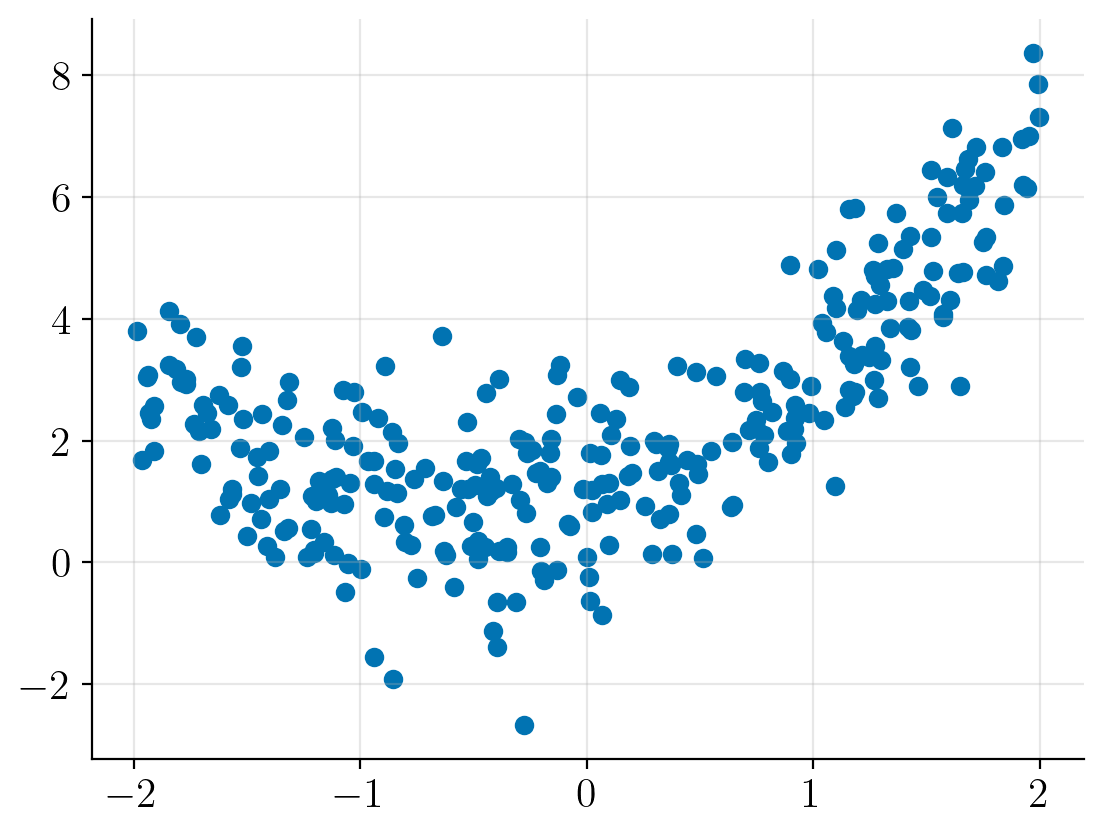

In [8]:
plt.scatter(X[:, 1], y)
plt.grid(alpha=0.3)

## Problem formulation

Observation model
$$
    p(y_t \vert \boldsymbol\theta_t, {\bf x}_t) = {\cal N}(y_t \vert {\bf x}_t^\intercal\boldsymbol\theta_t, \beta)
$$

with known observation precision $\tau$ and prior
$$
    p(\boldsymbol\theta_t) = {\cal N}\left(\boldsymbol\theta_t \vert \boldsymbol 0, \alpha^{-1}{\bf I}\right)
$$


### The components

**The predictive probability**

$$
\begin{aligned}
    p(\boldsymbol y_t \vert \boldsymbol\mu, \boldsymbol\Sigma, {\bf x}_t)
    &= \int p(\boldsymbol y_t, \boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma, {\bf x}_t) d\boldsymbol\theta\\
    &= \int p(\boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma)p(\boldsymbol y_t \vert \boldsymbol\theta, {\bf x}_t)d\boldsymbol\theta\\
    &= \int {\cal N}(\boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma)
    {\cal N}(\boldsymbol y_t \vert \boldsymbol\theta^\intercal {\bf x}_t, \beta^{-1})d\boldsymbol\theta\\
    &=
    {\cal N}(\boldsymbol y_t \vert \boldsymbol\mu^\intercal {\bf x}_t, \beta^{-1} + {\bf x}_t^\intercal\boldsymbol\Sigma{\bf x}_t)
\end{aligned}
$$

In [9]:
from rebayes_mini.callbacks import get_predicted_mean

In [10]:
def callback(bel, bel_prior, y, x):
    yhat = applyfn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [11]:
def applyfn(w, x):
    return jnp.atleast_1d(w @ x)

In [12]:
wprior = jnp.zeros(3)
static_agent = GaussianFilter(
    applyfn, dynamics_covariance=1e-5,
)

In [13]:
bel = static_agent.init_bel(wprior)
bel_final, hist = static_agent.scan(bel, y, X, callback)
means = hist["mean"]

In [14]:
errs = (hist["yhat"] - hist_dpg["yclean"]).ravel()

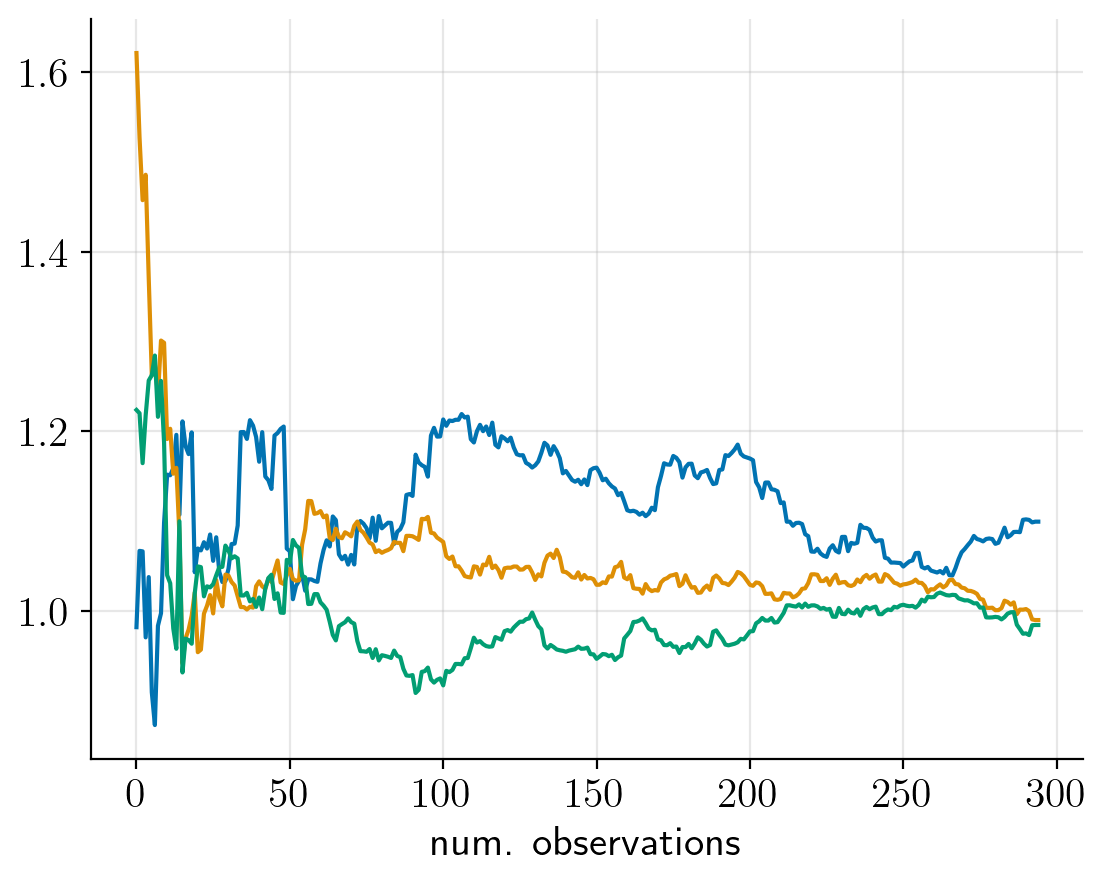

In [15]:
plt.plot(means[5:])
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

## An animation

In [16]:
X, y, errs = jax.tree.map(np.array, (X, y, errs))

In [17]:
errs = pd.Series(errs)

In [18]:
xmin, xmax = X[:, 1].min(), X[:, 1].max()
xeval = np.linspace(xmin, xmax)
xeval = np.c_[xeval ** 0, xeval ** 1, xeval ** 2]

In [19]:
from matplotlib.animation import FuncAnimation

In [ ]:
def animate(t, ax):
    for axi in ax:
        axi.cla()
    print(t, end="\r")
    ax[0].set_xlim(X[:, 1].min(), X[:, 1].max())
    ax[0].scatter(X[:t, 1], y[:t])
    ax[0].grid(alpha=0.3)
    ax[0].plot(xeval[:, 1], xeval @ means[t], c="black", linewidth=2)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    np.power(errs, 2).expanding().mean()[:t].plot(ax=ax[1], c="black")
    ax[1].set_yscale("log")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, n_samples)
    ax[1].set_title("RMSE")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
animation = FuncAnimation(fig, partial(animate,ax=ax), frames=np.arange(1, n_samples))
animation.save("sequential.gif", fps=20)

## Logistic regression

In [21]:
import einops
import flax.linen as nn
from moons_data import make_rotating_moons
from rebayes_mini.methods.gauss_filter import BernoulliFilter

In [22]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = jnp.sin(x)
        x = nn.Dense(5)(x)
        x = jnp.sin(x)
        x = nn.Dense(1)(x)
        return x



class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x


model = MLP()

In [23]:
n_samples = 200
(X, y, rads), test = make_rotating_moons(n_samples, 0, n_rotations=1, noise=0.2)

In [24]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
Xgrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

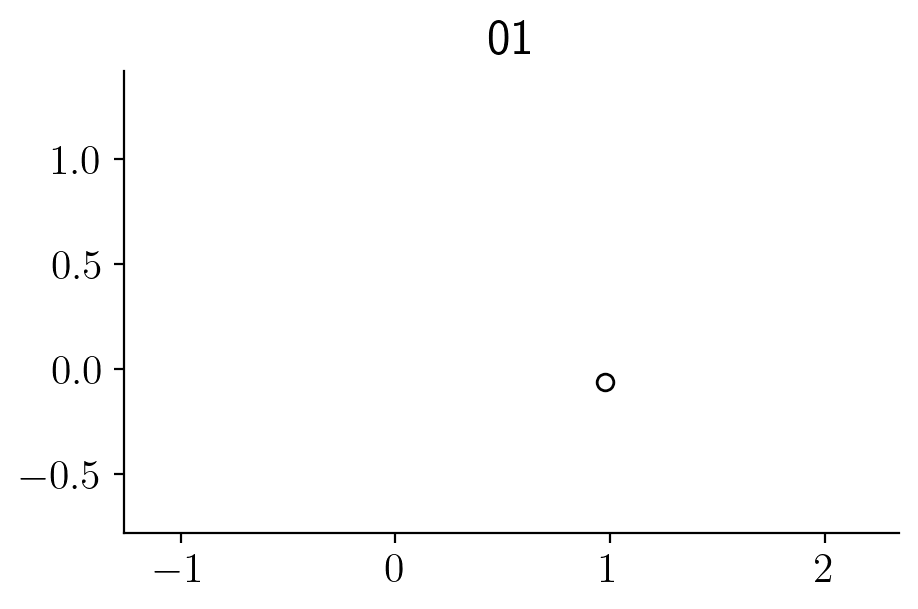

In [158]:
%%time
def animate(t, ax):
    print(t, end="\r")
    ax.cla()
    plt.scatter(*X[:t].T, c=y[:t], cmap="bone_r", edgecolor="black")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(f"{t:=02}")


fig, ax = plt.subplots(figsize=(5.0, 3.0))
animation = FuncAnimation(fig, partial(animate,ax=ax), frames=np.arange(1, n_samples))
animation.save("sequential-moons.gif", fps=20)

## Online learning

In [25]:
cmap = "RdBu_r"

In [26]:
params_init = model.init(key, X)

In [27]:
agent = BernoulliFilter(model.apply, dynamics_covariance=0.0)
bel_init = agent.init_bel(params_init)

In [28]:
def callback(bel, bel_prior, y, x):
    yhat = agent.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [29]:
bel_final, hist = agent.scan(bel_init, y, X, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [30]:
X, y = jax.tree.map(np.array, (X, y))

In [31]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

In [32]:
(yhat.ravel() == y).mean()

Array(0.85499996, dtype=float32)

In [33]:
errs = (yhat.ravel() == y)
X, y, errs = jax.tree.map(np.array, (X, y, errs))
errs = pd.Series(errs) * 1.0

In [ ]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_title(f"{t:=03}")

    
    errs.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=np.arange(len(y)))
animation.save("moons-c-static.gif", fps=15)

# Changepoints!

In [34]:
n_samples = 100
n_rotations = 3
(X, y, rads), test = make_rotating_moons(
    n_samples, 0, n_rotations=n_rotations, noise=0.2, seed=3141
)

In [35]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
Xgrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

## Plotting regimes

In [39]:
X.shape

(300, 2)

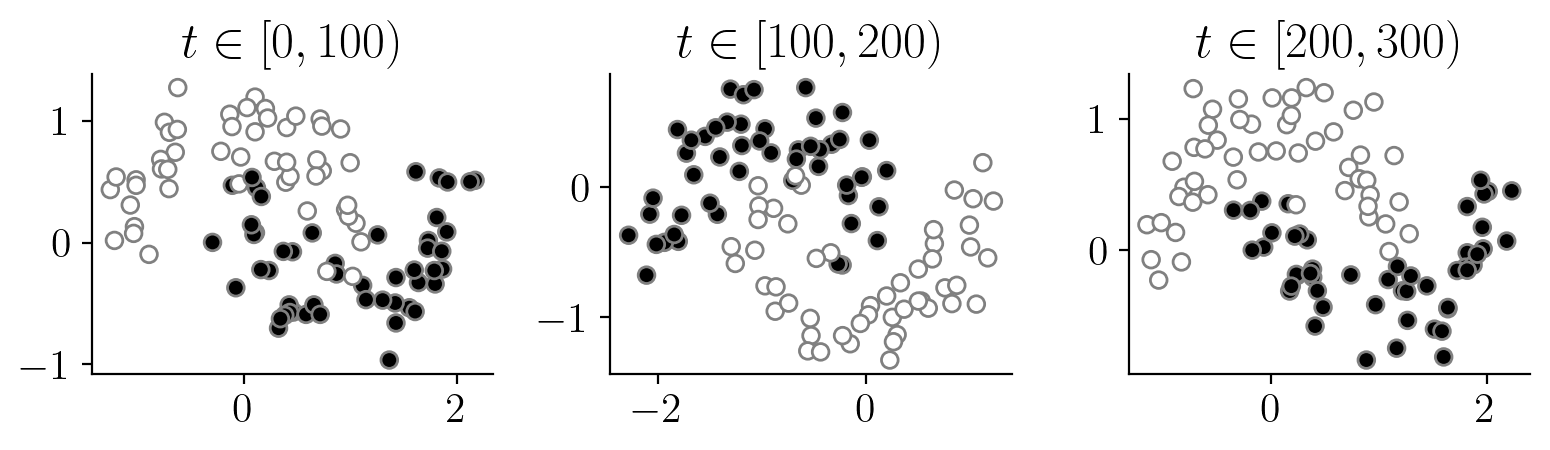

In [75]:
fig, ax = plt.subplots(1, n_rotations, figsize=(8, 2.5))
for i, axi in enumerate(ax):
    tinit, tend = i * n_samples, (i + 1) * n_samples
    tslice = slice(tinit, tend)
    Xsub = X[tslice]
    ysub = y[tslice]
    axi.set_title(f"$t \in [{tinit}, {tend})$")
    axi.scatter(*Xsub.T, c=ysub, cmap="bone_r", edgecolor="gray")
plt.tight_layout()
plt.savefig("mooons-dataset-split.png", dpi=200, bbox_inches="tight")

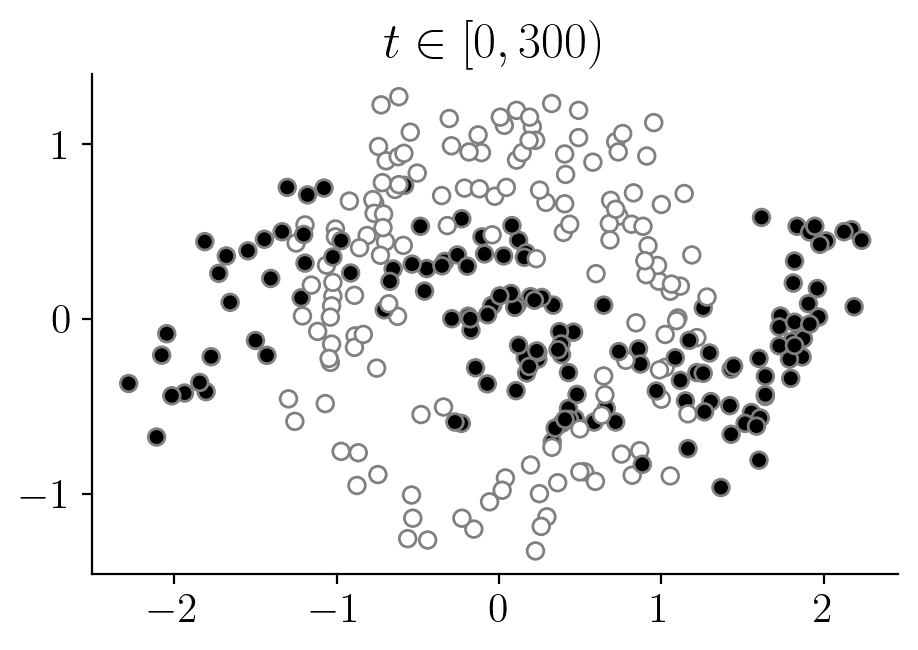

In [86]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.set_title(f"$t \in [0, {n_samples * n_rotations})$")
ax.scatter(*X.T, c=y, cmap="bone_r", edgecolor="gray")
plt.tight_layout()
plt.savefig("moons-dataset-full.png", dpi=200, bbox_inches="tight")

## C-static

In [119]:
params_init = model.init(key, X)

In [120]:
agent = BernoulliFilter(model.apply, dynamics_covariance=0.0)
bel_init = agent.init_bel(params_init)

In [121]:
def callback(bel, bel_prior, y, x):
    yhat = agent.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [122]:
bel_final, hist = agent.scan(bel_init, y, X, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [123]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

In [124]:
(yhat.ravel() == y).mean()

Array(0.6766667, dtype=float32)

In [125]:
errs_ccst = (yhat.ravel() == y)
X, y, errs_ccst = jax.tree.map(np.array, (X, y, errs_ccst))
errs_ccst = pd.Series(errs_ccst) * 1.0

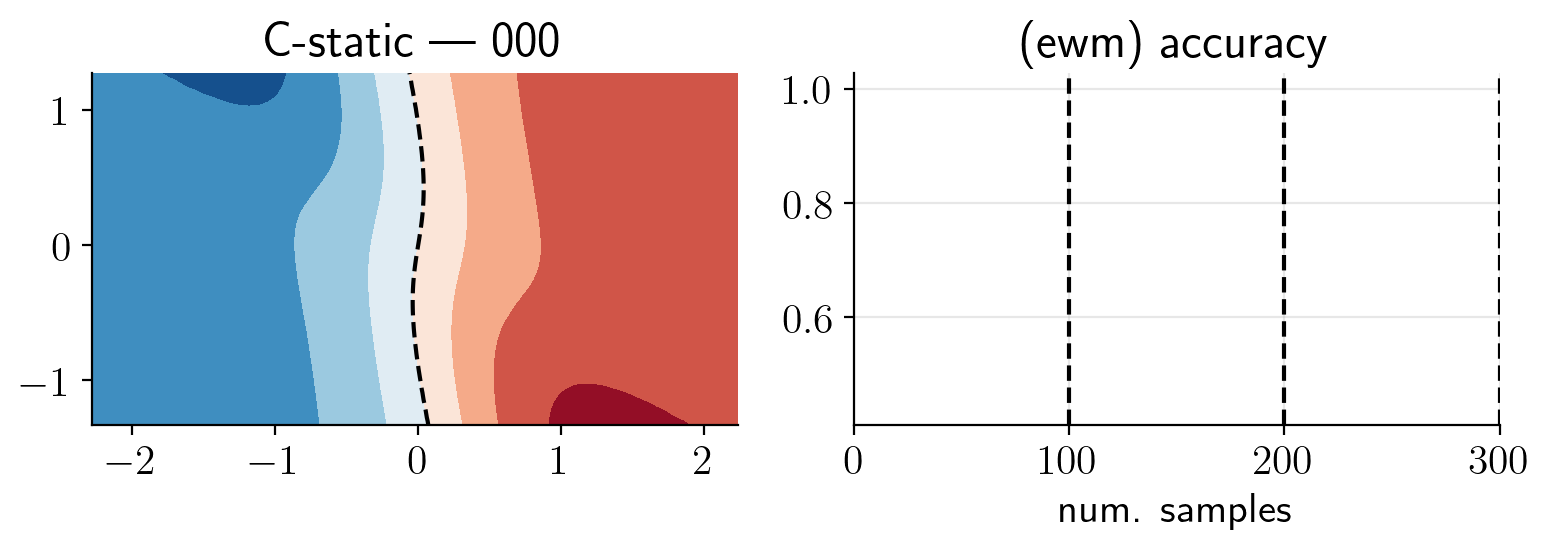

In [126]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_title(f"C-static | {t:=03}")

    for i in range(n_rotations):
        ax[1].axvline(x=(i+1) * n_samples, c="black", linestyle="--")

    
    errs_ccst.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=np.arange(len(y)))
animation.save("changes-moons-c-static.gif", fps=15)

## RLPR to the rescue?

In [127]:
from rebayes_mini.methods.adaptive import ExpfamRLPR

In [128]:
agent_base = BernoulliFilter(model.apply, 0.0)
agent = ExpfamRLPR(p_change=0.41, K=1, filter=agent_base)
bel_init = agent.init_bel(params_init, cov=1.0, log_joint_init=0.0)

In [129]:
def callback(bel, bel_prior, y, x):
    yhat = jax.vmap(agent.filter.link_fn, in_axes=(0, None))(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean,
        "runlenght": bel.runlength,
        "joint": bel.log_joint,
    }

In [130]:
bel_final, hist = agent.scan(y[:, None], X, bel_init, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [131]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

errs_rlpr = (yhat.ravel() == y)
X, y, errs_rlpr = jax.tree.map(np.array, (X, y, errs_rlpr))
errs_rlpr = pd.Series(errs_rlpr) * 1.0

In [132]:
(yhat.ravel() == y).mean()

Array(0.7966667, dtype=float32)

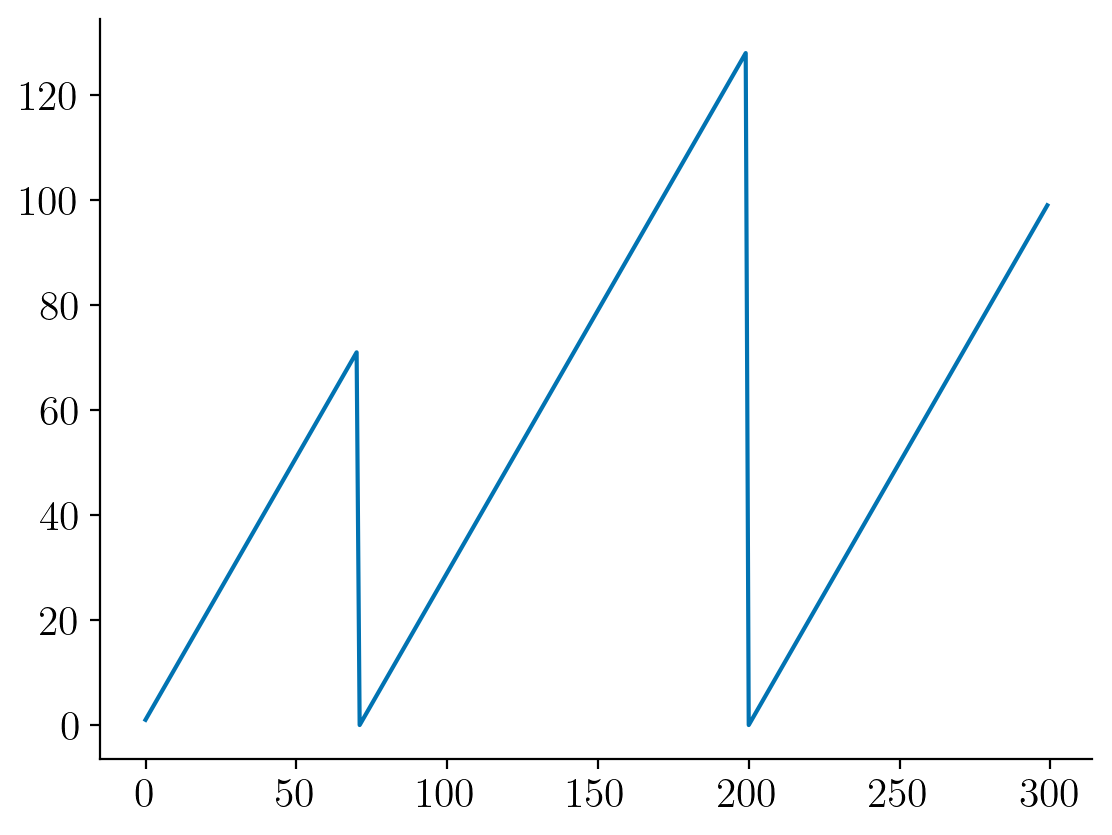

In [133]:
plt.plot(hist["runlenght"])

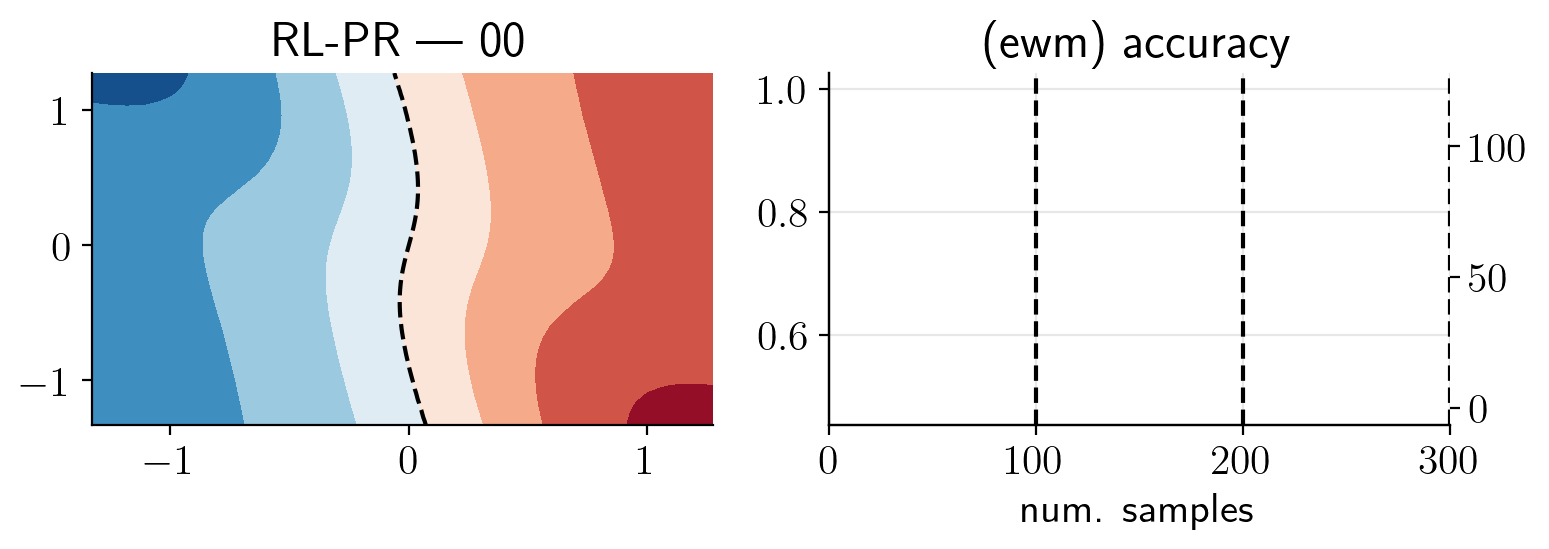

In [134]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.filter.link_fn(means[t,0], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)
    
    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_xlim(ymin, ymax)
    ax[0].set_title(f"RL-PR | {t:=02}")

    for i in range(n_rotations):
        ax[1].axvline(x=(i+1) * n_samples, c="black", linestyle="--")

    ax2.cla()
    errs_rlpr.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    ax2.plot(hist["runlenght"][:t], c="crimson", alpha=0.6)
    ax2.set_ylim(top=hist["runlenght"].max())
    
    plt.tight_layout()


fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax2 = ax[1].twinx()

# animation = FuncAnimation(fig, partial(animate,ax=ax), frames=np.arange(1, len(y), 1))
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=np.arange(len(y)))
animation.save("changes-moons-rl-pr.gif", fps=15)

## CPP-OU

In [135]:
from rebayes_mini.methods.adaptive import ExpfamEBA

In [136]:
agent_base = BernoulliFilter(model.apply, 0.0)
agent = ExpfamEBA(
    n_inner=3, ebayes_lr=1e-3, filter=agent_base,
    state_drift=1.5, deflate_mean=True, deflate_covariance=True
)
bel_init = agent.init_bel(params_init, cov=1.0)

In [137]:
def callback(bel, bel_prior, y, x):
    yhat = agent.filter.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean,
        "posterior": jnp.exp(-bel.eta/2),
    }

In [138]:
bel_final, hist = agent.scan(y[:, None], X, bel_init, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [139]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5
errs_cppou = (yhat.ravel() == y)
errs_cppou.mean()

Array(0.7733334, dtype=float32)

In [140]:
X, y, errs_cppou = jax.tree.map(np.array, (X, y, errs_cppou))
errs_cppou = pd.Series(errs_cppou) * 1.0

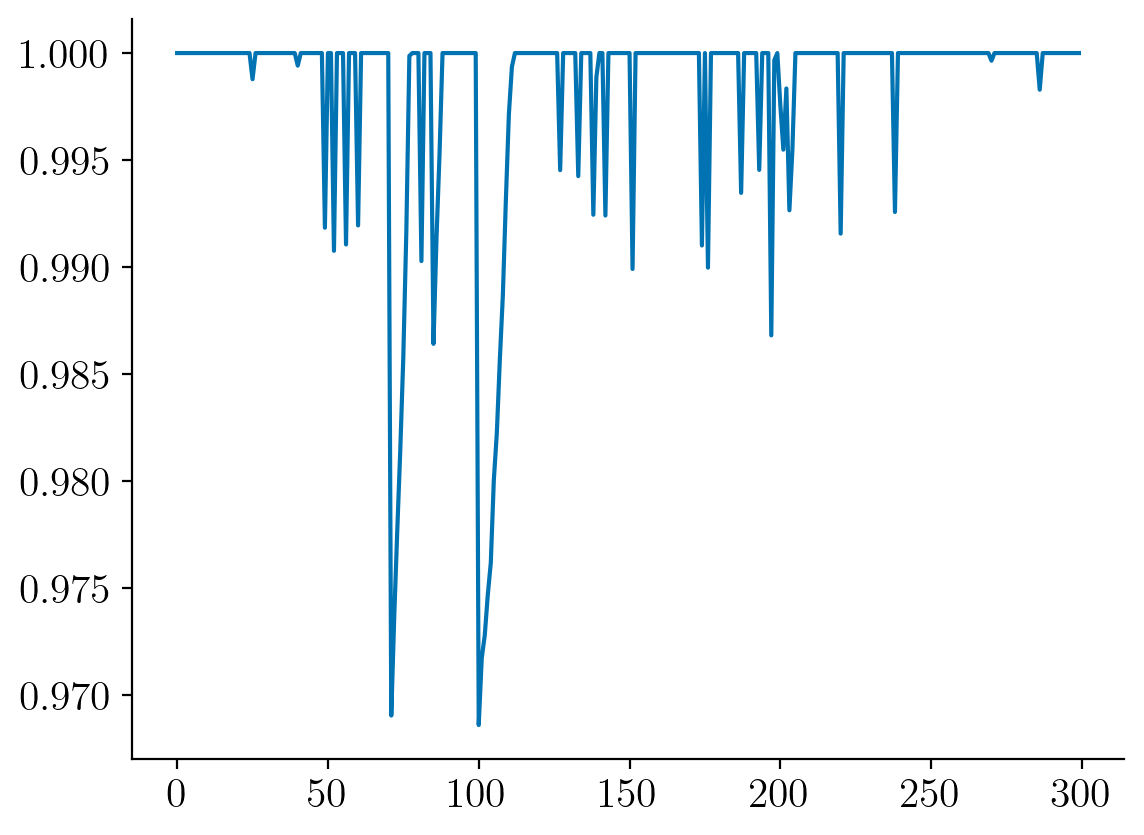

In [141]:
plt.plot(hist['posterior'])

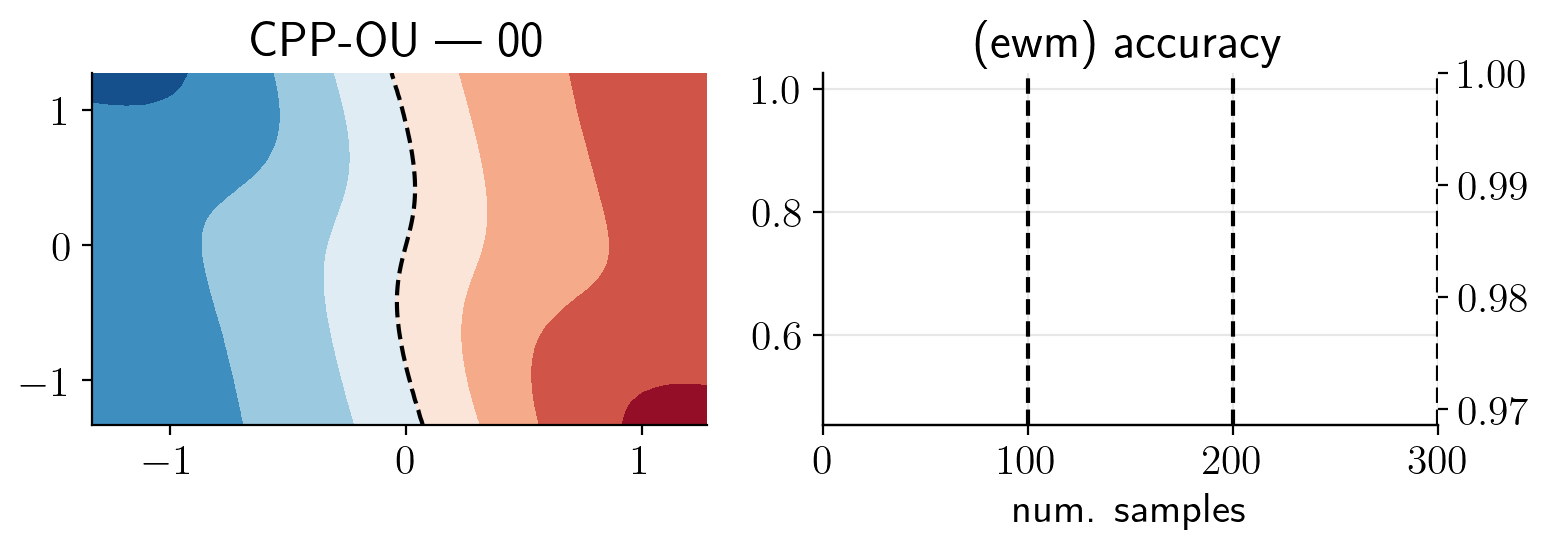

In [142]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.filter.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_xlim(ymin, ymax)
    ax[0].set_title(f"CPP-OU | {t:=02}")

    for i in range(n_rotations):
        ax[1].axvline(x=(i+1) * n_samples, c="black", linestyle="--")

    ax2.cla()
    errs_cppou.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    
    ax2.plot(hist["posterior"][:t], c="crimson", alpha=0.6)
    ax2.set_ylim(top=1.0, bottom=hist["posterior"].min())

    plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax2 = ax[1].twinx()
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=np.arange(len(y)))
animation.save("changes-moons-cpp-ou.gif", fps=15)

## C-ACI

In [143]:
params_init = model.init(key, X)

In [144]:
agent = BernoulliFilter(model.apply, dynamics_covariance=1e-3)
bel_init = agent.init_bel(params_init)

In [145]:
def callback(bel, bel_prior, y, x):
    yhat = agent.link_fn(bel_prior.mean, x)
    return {
        "yhat": yhat,
        "mean": bel_prior.mean
    }

In [146]:
bel_final, hist = agent.scan(bel_init, y, X, callback)
hist = jax.tree.map(np.array, hist)
means = hist["mean"]

In [147]:
yhat = jax.nn.sigmoid(hist["yhat"]) > 0.5

In [148]:
(yhat.ravel() == y).mean()

Array(0.7666667, dtype=float32)

In [149]:
errs_caci = (yhat.ravel() == y)
X, y, errs_caci = jax.tree.map(np.array, (X, y, errs_caci))
errs_caci = pd.Series(errs_caci) * 1.0

In [150]:
def animate(t, ax):
    print(t, end="\r")
    for axi in ax:
        axi.cla()
    Z = agent.link_fn(means[t], einops.rearrange(Xgrid, "d i j -> i j d")).squeeze()
    Z = np.array(Z)

    ax[0].contour(*Xgrid, Z, levels=0, colors="black", linestyles="--")
    ax[0].contourf(*Xgrid, Z, cmap=cmap)
    tmin = (t // n_samples) * n_samples
    ax[0].scatter(*X[tmin:t].T, c=y[tmin:t], cmap="bone_r", edgecolor="black")
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_title(f"C-ACI | {t:=03}")

    for i in range(n_rotations):
        ax[1].axvline(x=(i+1) * n_samples, c="black", linestyle="--")

    
    errs_caci.ewm(span=50).mean()[:t].plot(ax=ax[1], c="black")
    ax[1].grid(alpha=0.3)
    ax[1].set_xlim(0, len(y))
    ax[1].set_title("(ewm) accuracy")
    ax[1].set_xlabel("num. samples")
    plt.tight_layout()

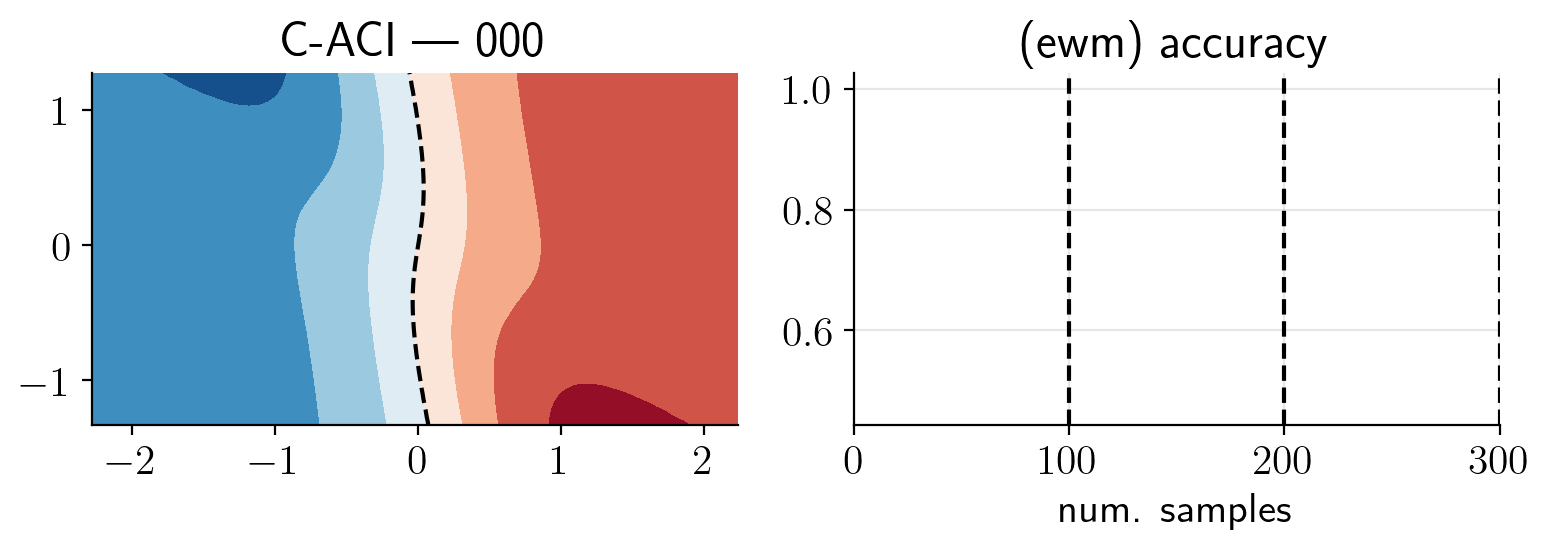

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
animation = FuncAnimation(fig, partial(animate, ax=ax), frames=np.arange(len(y)))
animation.save("changes-moons-c-aci.gif", fps=15)

## All errors

In [152]:
errs_all = pd.DataFrame({
    "C-Static": errs_ccst,
    "RL-PR": errs_rlpr,
    "CPP-OU": errs_cppou,
    "C-ACI": errs_caci,
})

errs_all.columns = [r"$\texttt{" + c + "}$" for c in errs_all.columns]

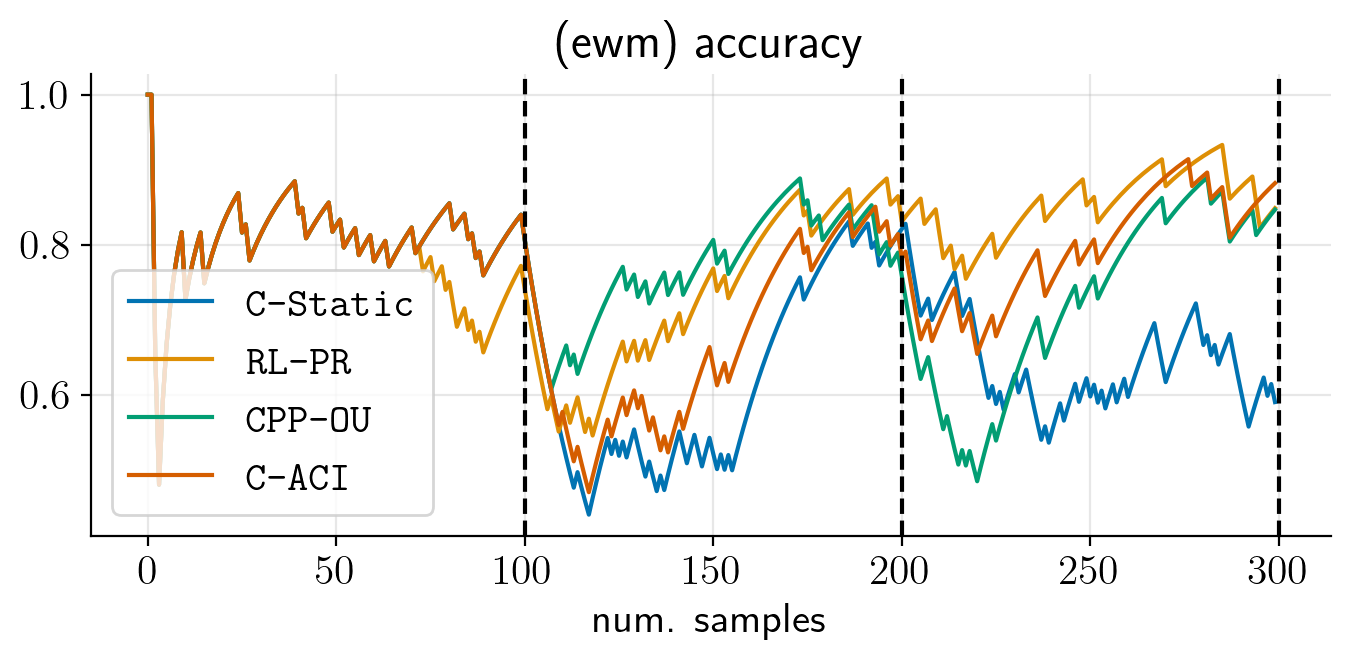

In [153]:
fig, ax = plt.subplots(figsize=(8, 3))

errs_all.ewm(span=50).mean().plot(ax=ax)

for i in range(n_rotations):
    plt.axvline(x=(i+1) * n_samples, c="black", linestyle="--")

plt.title("(ewm) accuracy")
plt.xlabel("num. samples")
plt.grid(alpha=0.3)
plt.savefig("changes-mooons-comparison.png", dpi=200)

$$
    F_d = \sum_{i=1}^j A_{d,i}(Y_{1:j})_{i,d}
$$